In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [61]:
# Load the dataset

df = pd.read_csv('/content/weather_data_sylhet.csv')


In [62]:
print(df.head()) # Display the first few rows


   Year  Day  Wind Speed  Specific Humidity  Relative Humidity  Precipitation  \
0  1990    1        1.08               5.68              53.06            0.0   
1  1990    2        1.13               5.92              58.06            0.0   
2  1990    3        1.33               5.68              52.69            0.0   
3  1990    4        1.09               5.19              47.19            0.0   
4  1990    5        0.94               4.82              42.88            0.0   

   Temperature  
0        16.33  
1        15.68  
2        16.56  
3        17.09  
4        17.26  


In [63]:
print(df.info()) # Get data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12113 entries, 0 to 12112
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               12113 non-null  int64  
 1   Day                12113 non-null  int64  
 2   Wind Speed         12113 non-null  float64
 3   Specific Humidity  12113 non-null  float64
 4   Relative Humidity  12113 non-null  float64
 5   Precipitation      12113 non-null  float64
 6   Temperature        12113 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 662.6 KB
None


In [64]:
print(df.describe()) # Summary statistics for numerical columns

               Year           Day    Wind Speed  Specific Humidity  \
count  12113.000000  12113.000000  12113.000000       12113.000000   
mean    2006.084207    182.365475      1.311912          15.207111   
std        9.573148    105.730770      0.539321           5.529803   
min     1990.000000      1.000000      0.440000           2.620000   
25%     1998.000000     90.000000      0.950000           9.950000   
50%     2006.000000    182.000000      1.150000          16.170000   
75%     2014.000000    274.000000      1.520000          20.570000   
max     2023.000000    366.000000      5.340000          24.290000   

       Relative Humidity  Precipitation   Temperature  
count       12113.000000   12113.000000  12113.000000  
mean           74.635416       7.183984     25.038147  
std            15.286193      13.126254      4.373427  
min            15.810000       0.000000     11.190000  
25%            65.250000       0.000000     21.430000  
50%            79.620000       1.

In [65]:
print(df.isnull().sum()) # Count missing values in each column

# Example: Impute missing numerical values with the mean
for col in df.select_dtypes(include=[np.number]).columns: # Select numerical columns
    df[col].fillna(df[col].mean(), inplace=True)

# Example: Impute missing categorical values with mode (if needed)
# df['CategoricalColumn'].fillna(df['CategoricalColumn'].mode()[0], inplace=True)

Year                 0
Day                  0
Wind Speed           0
Specific Humidity    0
Relative Humidity    0
Precipitation        0
Temperature          0
dtype: int64


<ipython-input-65-2b3ba9b506ba>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


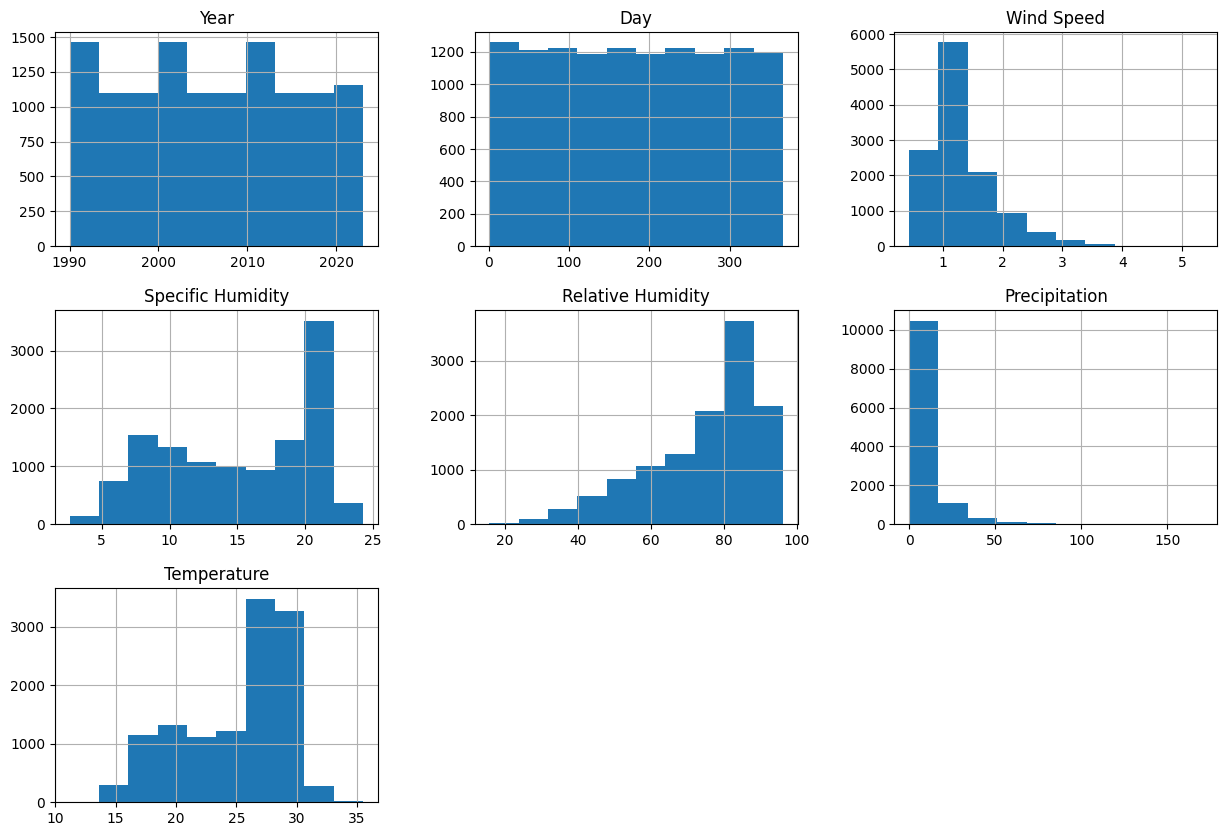

In [66]:
# Visualizing the distribution of numerical features to understand their patterns and identify potential outliers.

df.hist(figsize=(15,10)) # Histograms for all numerical columns
plt.show()

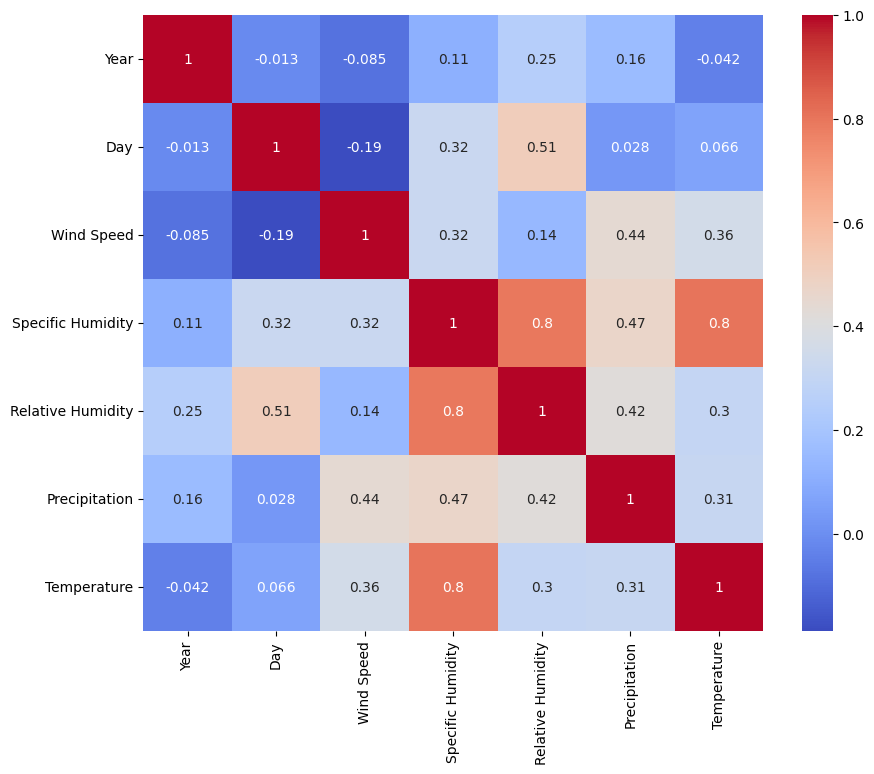

In [67]:
#Understanding how different features correlate with each other.

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm') # Correlation heatmap
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best parameters for Rain Prediction: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score for Rain Prediction: 0.8968720628618507
Rain Prediction - Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      1617
         1.0       0.92      0.87      0.90      1549

    accuracy                           0.90      3166
   macro avg       0.90      0.90      0.90      3166
weighted avg       0.90      0.90      0.90      3166

Rain Prediction - Accuracy: 0.9005053695514845
Rain Prediction - Confusion Matrix:
 [[1505  112]
 [ 203 1346]]


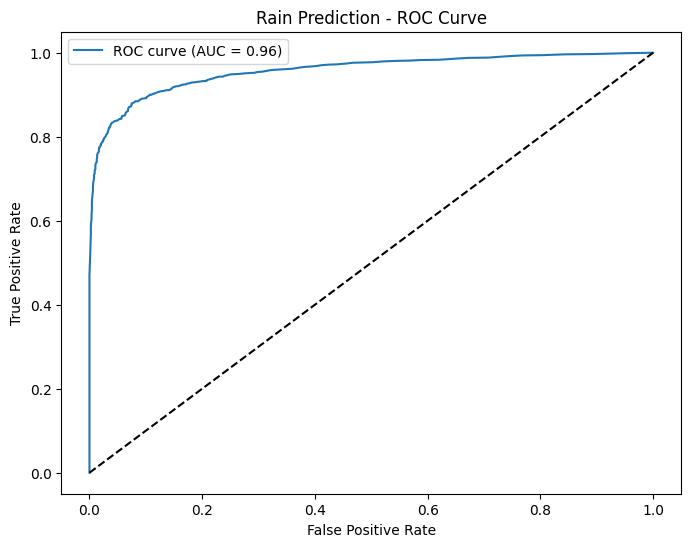

In [68]:
# Create 'RainToday' column based on 'Precipitation'
df['RainToday'] = df['Precipitation'].apply(lambda x: 1 if x > 0 else 0) # 1 for Rain, 0 for No Rain

# Handling missing values using SimpleImputer again
numerical_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Prepare data - Feature selection and target variable for rain prediction
features_rain = ['Wind Speed', 'Specific Humidity', 'Relative Humidity', 'Temperature']
X_rain = df[features_rain]
y_rain = df['RainToday']

# Handling imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_rain_resampled, y_rain_resampled = smote.fit_resample(X_rain, y_rain)

# Split data
X_train_rain, X_test_rain, y_train_rain, y_test_rain = train_test_split(X_rain_resampled, y_rain_resampled, test_size=0.2, random_state=42)

# Feature Scaling (StandardScaler)
scaler_rain = StandardScaler()
X_train_scaled_rain = scaler_rain.fit_transform(X_train_rain)
X_test_scaled_rain = scaler_rain.transform(X_test_rain)

# Model Training (Random Forest Classifier as example)
model_rain = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search_rain = GridSearchCV(model_rain, param_grid, cv=5, scoring='accuracy')
grid_search_rain.fit(X_train_scaled_rain, y_train_rain)

# Best parameters and score
print("Best parameters for Rain Prediction:", grid_search_rain.best_params_)
print("Best cross-validation score for Rain Prediction:", grid_search_rain.best_score_)

# Predictions
y_pred_rain = grid_search_rain.predict(X_test_scaled_rain)
y_prob_rain = grid_search_rain.predict_proba(X_test_scaled_rain)[:, 1]

# Evaluation
print("Rain Prediction - Classification Report:\n", classification_report(y_test_rain, y_pred_rain))
print("Rain Prediction - Accuracy:", accuracy_score(y_test_rain, y_pred_rain))
print("Rain Prediction - Confusion Matrix:\n", confusion_matrix(y_test_rain, y_pred_rain))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_rain, y_prob_rain)
roc_auc = roc_auc_score(y_test_rain, y_prob_rain)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Rain Prediction - ROC Curve')
plt.legend()
plt.show()

In [75]:
# Prepare data for humidity regression (predicting 'Relative Humidity')
features_humidity = ['Temperature', 'Wind Speed', 'Specific Humidity', 'Precipitation']
X_humidity = df[features_humidity]
y_humidity = df['Relative Humidity']

# Handling missing values using SimpleImputer
X_humidity = imputer.fit_transform(X_humidity)
y_humidity = imputer.fit_transform(y_humidity.values.reshape(-1, 1)).flatten()

# Split data
X_train_humidity, X_test_humidity, y_train_humidity, y_test_humidity = train_test_split(X_humidity, y_humidity, test_size=0.2, random_state=42)

# Feature Scaling (StandardScaler)
scaler_humidity = StandardScaler()
X_train_scaled_humidity = scaler_humidity.fit_transform(X_train_humidity)
X_test_scaled_humidity = scaler_humidity.transform(X_test_humidity)

# Model Training (Gradient Boosting Regressor as example)
model_humidity = GradientBoostingRegressor(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_search_humidity = GridSearchCV(model_humidity, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_humidity.fit(X_train_scaled_humidity, y_train_humidity)

# Best parameters and score
print("Best parameters for Humidity Prediction:", grid_search_humidity.best_params_)
print("Best cross-validation score for Humidity Prediction:", -grid_search_humidity.best_score_)

# Predictions
y_pred_humidity = grid_search_humidity.predict(X_test_scaled_humidity)

# Evaluation
print("Humidity Prediction - Mean Squared Error (MSE):", mean_squared_error(y_test_humidity, y_pred_humidity))
print("Humidity Prediction - Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test_humidity, y_pred_humidity)))
print("Humidity Prediction - Mean Absolute Error (MAE):", mean_absolute_error(y_test_humidity, y_pred_humidity))
print("Humidity Prediction - R-squared:", r2_score(y_test_humidity, y_pred_humidity))


Best parameters for Humidity Prediction: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score for Humidity Prediction: 0.5987156045520742
Humidity Prediction - Mean Squared Error (MSE): 0.6502789862474931
Humidity Prediction - Root Mean Squared Error (RMSE): 0.8063987761941936
Humidity Prediction - Mean Absolute Error (MAE): 0.5748630024776912
Humidity Prediction - R-squared: 0.9972945908040782


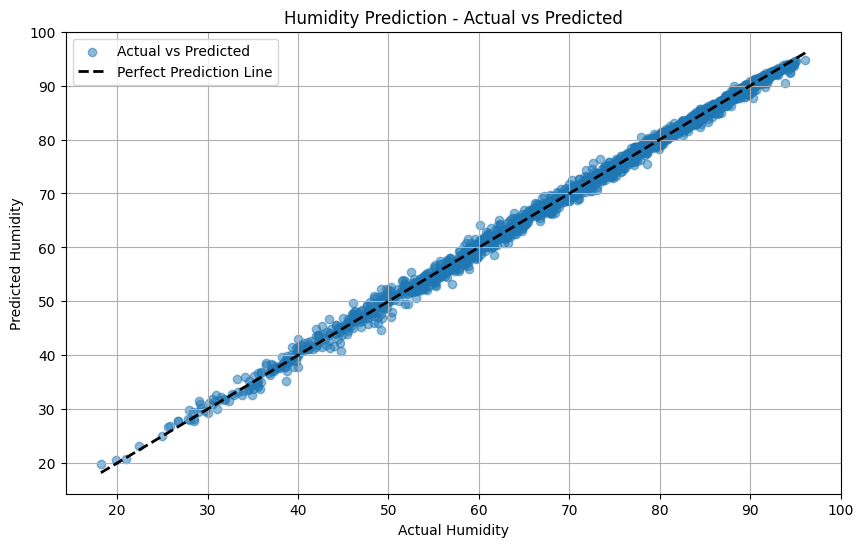

In [78]:
# Additional visualization for Humidity Prediction
plt.figure(figsize=(10, 6))
plt.scatter(y_test_humidity, y_pred_humidity, alpha=0.5, label='Actual vs Predicted')
plt.plot([y_test_humidity.min(), y_test_humidity.max()], [y_test_humidity.min(), y_test_humidity.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Humidity')
plt.ylabel('Predicted Humidity')
plt.title('Humidity Prediction - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()